In [4]:
from sklearn.cross_validation import KFold
from sklearn.preprocessing import Imputer, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

import math
import pandas as pd
import pdb
import numpy as np
from tables import *
import gcp.bigquery as bq
import gcp.storage as storage
try:
  import cPickle as pickle
except:
  import pickle
FIELDS_PICKLE = 'fields-4.pkl'
DATAFILE_PATH = 'xjk_pytable.h5'

seed = 13
np.random.seed(seed)

fields = pickle.load(open(FIELDS_PICKLE, "r") )
fields_original = fields[:]
features = fields[1:]

# Use this instead of len(features) since this variable can change
# e.g. when one hot encoding is used and/or new features are added.
n_features = len(features)

print "Number of features: {}".format(len(features))
print "Fields:"
for a, b in enumerate(fields):
  print '{}. {}'.format(a, b)
weather_field_ids = [3, 4, 5, 18, 19, 20, 21, 22, 23]


Number of features: 163
Fields:
0. gap
1. timeofday_slot
2. day_in_week
3. weather_1_slots_ago
4. weather_2_slots_ago
5. weather_3_slots_ago
6. tj_level1_1_slots_ago
7. tj_level2_1_slots_ago
8. tj_level3_1_slots_ago
9. tj_level4_1_slots_ago
10. tj_level1_2_slots_ago
11. tj_level2_2_slots_ago
12. tj_level3_2_slots_ago
13. tj_level4_2_slots_ago
14. tj_level1_3_slots_ago
15. tj_level2_3_slots_ago
16. tj_level3_3_slots_ago
17. tj_level4_3_slots_ago
18. temperature_1_slots_ago
19. pm25_1_slots_ago
20. temperature_2_slots_ago
21. pm25_2_slots_ago
22. temperature_3_slots_ago
23. pm25_3_slots_ago
24. gap_1_slots_ago
25. sum_price_1_slots_ago
26. gap_2_slots_ago
27. sum_price_2_slots_ago
28. gap_3_slots_ago
29. sum_price_3_slots_ago
30. f1
31. f11
32. f11_1
33. f11_2
34. f11_3
35. f11_4
36. f11_5
37. f11_6
38. f11_7
39. f11_8
40. f13_4
41. f13_8
42. f14
43. f14_1
44. f14_10
45. f14_2
46. f14_3
47. f14_6
48. f14_8
49. f15
50. f15_1
51. f15_2
52. f15_3
53. f15_4
54. f15_6
55. f15_7
56. f15_8
57. 

# Overview
In this section, we will see how the handling of missing data will affect performance. We will do a quick spot-checking, that is to create a baseline model with fast-running algorithm, then compare its performance with and without preprocessing missing data as explained above.

The data will be tested with DecisionTree algorithm, and it will be cross-validated with 10-kfold splits. We won't do any grid search at this step as we only want to see if missing data handling works.

In [5]:
def mape(y, predictions):
  if len(y.shape) == 1:
    y = np.asmatrix(y)
  if len(predictions.shape) == 1:
    predictions = np.asmatrix(predictions)
  y = y.astype(float)
  predictions = predictions.astype(float)
  return np.mean(np.absolute((y-predictions)/y))

# from keras import backend as K

# def mape(y, predictions):
#   return K.mean(K.abs(y-predictions/K.clip(K.abs(y), K.epsilon(), np.inf)), axis=-1)

mape_scorer = make_scorer(mape, greater_is_better=False)

# Load Dataset

In [6]:
fileh1 = open_file(DATAFILE_PATH, mode = 'r')

object = fileh1.get_node('/train', 'gaps')
object_array_data = object.read()
fileh1.close()

# Convert to vectorized array that we can use in further processing.
all_data = np.zeros((object_array_data.shape[0], len(fields)))
print 'there are {} rows'.format(object_array_data.shape[0])
for rcounter, row in enumerate(object_array_data):
  for fcounter, field in enumerate(fields):
    all_data[rcounter, fcounter] = row[field]
  if rcounter % 5000 == 0:
    print 'processed {} rows'.format(rcounter)
all_data_original = np.copy(all_data)

there are 102592 rows
processed 0 rows
processed 5000 rows
processed 10000 rows
processed 15000 rows
processed 20000 rows
processed 25000 rows
processed 30000 rows
processed 35000 rows
processed 40000 rows
processed 45000 rows
processed 50000 rows
processed 55000 rows
processed 60000 rows
processed 65000 rows
processed 70000 rows
processed 75000 rows
processed 80000 rows
processed 85000 rows
processed 90000 rows
processed 95000 rows
processed 100000 rows


# Baseline

In [7]:
all_data = np.copy(all_data_original)
all_data[np.isnan(all_data)] = 0
data = all_data[:,1:]
targets = all_data[:,0]
from sklearn.cross_validation import KFold
from sklearn.preprocessing import Imputer, OneHotEncoder
from sklearn.pipeline import Pipeline

steps = [
  ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3, 4], sparse=False,
                            n_values=[145, 7, 10, 10, 10])),
  ('estimate', LinearRegression())
]


folds = KFold(len(targets), n_folds=10, shuffle=True, random_state=seed)
scores = []
for fold, (train_ids, test_ids) in enumerate(folds):
  print "Now training fold {}".format(fold+1)
  est = Pipeline(steps)
  est.fit(data[train_ids], targets[train_ids])
  preds = est.predict(data[test_ids])
  score = mape(targets[test_ids], preds)
  scores.append(score)
  print "Score: {}".format(score)

Now training fold 1
Score: 1.58425959602
Now training fold 2
Score: 1.61331229877
Now training fold 3
Score: 1.65189546002
Now training fold 4
Score: 1.60147081944
Now training fold 5
Score: 1.63485116423
Now training fold 6
Score: 1.5860986638
Now training fold 7
Score: 1.65538747888
Now training fold 8
Score: 1.65070478932
Now training fold 9
Score: 1.61948557512
Now training fold 10
Score: 1.59540609461


In [8]:
score_ = sum(scores)/len(scores)
print "Mean score: {}".format(score_)

Mean score: 1.61928719402


# Handle Missing Data

1. Remove weather features.
2. Remove all data of district 54.
3. Replace missing `tj_level` data points with values from past timeslots.
4. Replace the rest of missing data (which would be gap related) with 0.

## Remove weather features and district 54

In [9]:
%%sql --module distnums
SELECT district_id, rownum FROM (
    SELECT district_id, ROW_NUMBER() OVER (ORDER BY district_id, timeslot) AS rownum
    FROM [datalab-projects-1331:xjk_algo_comp.gaps]
    WHERE gap > 0
) WHERE district_id = 54

In [10]:
all_data = np.copy(all_data_original)
fields = fields_original[:]
print "Shape of all data before: {}".format(all_data_original.shape)

# Remove weather features
fields = np.delete(fields, weather_field_ids, 0).tolist()
features = fields[1:]
n_features = len(features)
print "Number of features: {}".format(len(features))
print "Features:"
print features

all_data = np.delete(all_data, weather_field_ids, 1)

# Remove district 54
rows = bq.Query(distnums).to_dataframe()['rownum'].tolist()
print "number of observations removed: {}".format(len(rows))
all_data = np.delete(all_data, rows, 0)

# Replace tj_levels with past values
to_replace_list = [
  ['tj_level1_1_slots_ago', 0],
  ['tj_level2_1_slots_ago', 0],
  ['tj_level3_1_slots_ago', 0],
  ['tj_level4_1_slots_ago', 0],
  ['tj_level1_2_slots_ago', 0],
  ['tj_level2_2_slots_ago', 0],
  ['tj_level3_2_slots_ago', 0],
  ['tj_level4_2_slots_ago', 0],
  ['tj_level1_3_slots_ago', 0],
  ['tj_level2_3_slots_ago', 0],
  ['tj_level3_3_slots_ago', 0],
  ['tj_level4_3_slots_ago', 0],
]
for datum in all_data:
  for id, (title, value) in enumerate(to_replace_list):
    if math.isnan(datum[fields.index(title)]):
      datum[fields.index(title)] = to_replace_list[id][1]
    to_replace_list[id][1] = datum[fields.index(title)]

print "Shape of all data after: {}".format(all_data.shape)

data = all_data[:,1:]
targets = all_data[:,0]

Shape of all data before: (102592, 164)
Number of features: 154
Features:
['timeofday_slot', 'day_in_week', 'tj_level1_1_slots_ago', 'tj_level2_1_slots_ago', 'tj_level3_1_slots_ago', 'tj_level4_1_slots_ago', 'tj_level1_2_slots_ago', 'tj_level2_2_slots_ago', 'tj_level3_2_slots_ago', 'tj_level4_2_slots_ago', 'tj_level1_3_slots_ago', 'tj_level2_3_slots_ago', 'tj_level3_3_slots_ago', 'tj_level4_3_slots_ago', 'gap_1_slots_ago', 'sum_price_1_slots_ago', 'gap_2_slots_ago', 'sum_price_2_slots_ago', 'gap_3_slots_ago', 'sum_price_3_slots_ago', 'f1', 'f11', 'f11_1', 'f11_2', 'f11_3', 'f11_4', 'f11_5', 'f11_6', 'f11_7', 'f11_8', 'f13_4', 'f13_8', 'f14', 'f14_1', 'f14_10', 'f14_2', 'f14_3', 'f14_6', 'f14_8', 'f15', 'f15_1', 'f15_2', 'f15_3', 'f15_4', 'f15_6', 'f15_7', 'f15_8', 'f16', 'f16_1', 'f16_10', 'f16_11', 'f16_12', 'f16_3', 'f16_4', 'f16_6', 'f17', 'f17_2', 'f17_3', 'f17_4', 'f17_5', 'f19', 'f19_1', 'f19_2', 'f19_3', 'f19_4', 'f1_1', 'f1_10', 'f1_11', 'f1_2', 'f1_3', 'f1_4', 'f1_5', 'f1_6', 

In [11]:
# Create table showing features with null values when exist.

nulls = np.isnan(all_data)
nullspos = np.column_stack(np.where(nulls==True))
from operator import itemgetter
print "total data points:", (all_data.shape[0] * all_data.shape[1])
print "number of missing values:", nullspos.shape[0]
if nullspos.shape[0] > 0:
  missing_features = itemgetter(*np.unique(nullspos[:,1]).tolist())(fields)
  missing_features_table = pd.DataFrame(columns=['id', 'field', 'missing data points'])

  for id, field in enumerate(fields):
    total_missing = len(np.where(nullspos[:,1]==id)[0])
    if total_missing > 0:
      missing_features_table = missing_features_table.append({
          'id': id,
          'field': field,
          'missing data points': total_missing
        }, ignore_index=True)
  missing_features_table['missing data points'] = \
    missing_features_table['missing data points'].astype('int64')
  missing_features_table['id'] = \
    missing_features_table['id'].astype('int64')
  print missing_features_table.sort_values(['missing data points', 'id'], ascending=[False, True])

total data points: 15739475
number of missing values: 29750
   id                  field  missing data points
4  19        gap_3_slots_ago                 5364
5  20  sum_price_3_slots_ago                 5364
2  17        gap_2_slots_ago                 5063
3  18  sum_price_2_slots_ago                 5063
0  15        gap_1_slots_ago                 4448
1  16  sum_price_1_slots_ago                 4448


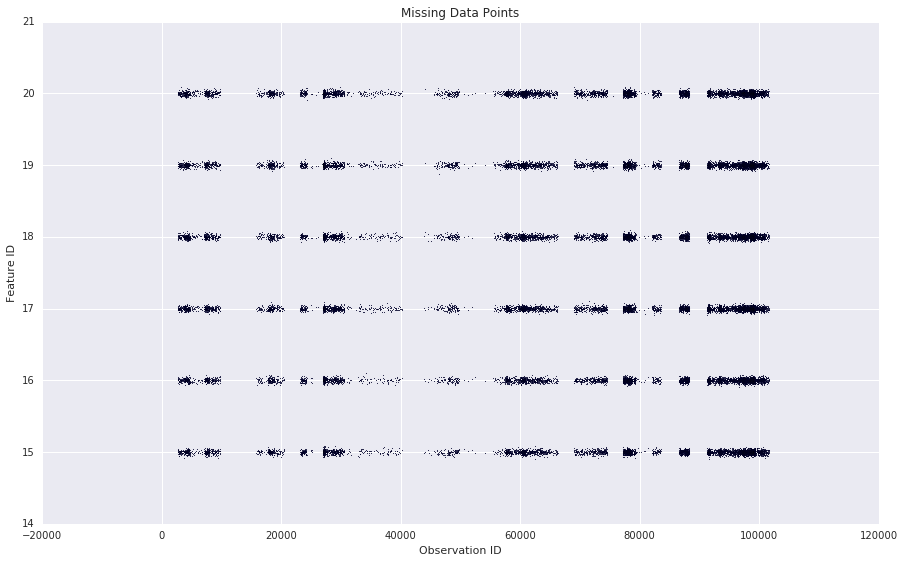

In [12]:
# Plot features with null values when exist.

import matplotlib
import matplotlib.pyplot as plt
if nullspos.shape[0] > 0:
  matplotlib.rcParams['figure.figsize'] = (15.0, 9.0)
  def rand_jitter(arr):
      stdev = .005*(max(arr)-min(arr))
      return arr + np.random.randn(len(arr)) * stdev
  _ = plt.scatter(nullspos[:,0], rand_jitter(nullspos[:,1]), s=0.5)
  _ = plt.title('Missing Data Points')
  _ = plt.ylabel('Feature ID')
  _ = plt.xlabel('Observation ID')

In [13]:
# Replace rest of data with 0    
all_data[np.isnan(all_data)] = 0

steps = [
  ('one_hot', OneHotEncoder(categorical_features=[0, 1], sparse=False,
                            n_values=[145, 7])),
  ('estimate', LinearRegression())
]


folds = KFold(len(targets), n_folds=10, shuffle=True, random_state=seed)
scores = []
for fold, (train_ids, test_ids) in enumerate(folds):
  print "Now training fold {}".format(fold+1)
  est = Pipeline(steps)
  est.fit(data[train_ids], targets[train_ids])
  preds = est.predict(data[test_ids])
  score = mape(targets[test_ids], preds)
  scores.append(score)
  print "Score: {}".format(score)

Now training fold 1
Score: 1.59852399203
Now training fold 2
Score: 1.61560400321
Now training fold 3
Score: 1.60419341443
Now training fold 4
Score: 1.58818515001
Now training fold 5
Score: 1.64012992062
Now training fold 6
Score: 1.56187921918
Now training fold 7
Score: 1.62477105034
Now training fold 8
Score: 1.6320748318
Now training fold 9
Score: 1.57623866083
Now training fold 10
Score: 1.57178240604


In [14]:
score_wd = sum(scores)/len(scores)
print "Mean score: {}".format(score_wd)

Mean score: 1.60133826485


## Only remove district 54 observations and replace tj_levels
What if we keep weather features?

In [ ]:
all_data = np.copy(all_data_original)
fields = fields_original[:]
print "Shape of all data before: {}".format(all_data_original.shape)

# Remove district 54
rows = bq.Query(distnums).to_dataframe()['rownum'].tolist()
all_data = np.delete(all_data, rows, 0)

# Replace tj_levels with past values
to_replace_list = [
  ['tj_level1_1_slots_ago', 0],
  ['tj_level2_1_slots_ago', 0],
  ['tj_level3_1_slots_ago', 0],
  ['tj_level4_1_slots_ago', 0],
  ['tj_level1_2_slots_ago', 0],
  ['tj_level2_2_slots_ago', 0],
  ['tj_level3_2_slots_ago', 0],
  ['tj_level4_2_slots_ago', 0],
  ['tj_level1_3_slots_ago', 0],
  ['tj_level2_3_slots_ago', 0],
  ['tj_level3_3_slots_ago', 0],
  ['tj_level4_3_slots_ago', 0],
]
for datum in all_data:
  for id, (title, value) in enumerate(to_replace_list):
    if math.isnan(datum[fields.index(title)]):
      datum[fields.index(title)] = to_replace_list[id][1]
    to_replace_list[id][1] = datum[fields.index(title)]

# Replace rest of data with 0    
all_data[np.isnan(all_data)] = 0

print "Shape of all data after: {}".format(all_data.shape)

data = all_data[:,1:]
targets = all_data[:,0]

Shape of all data before: (102592, 164)
Shape of all data after: (101545, 164)


In [ ]:
steps = [
  ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3, 4], sparse=False,
                            n_values=[145, 7, 10, 10, 10])),
  ('estimate', LinearRegression())
]


folds = KFold(len(targets), n_folds=10, shuffle=True, random_state=seed)
scores = []
for fold, (train_ids, test_ids) in enumerate(folds):
  print "Now training fold {}".format(fold+1)
  est = Pipeline(steps)
  est.fit(data[train_ids], targets[train_ids])
  preds = est.predict(data[test_ids])
  score = mape(targets[test_ids], preds)
  scores.append(score)
  print "Score: {}".format(score)

Now training fold 1
Score: 1.61288052562
Now training fold 2
Score: 1.62876070664
Now training fold 3
Score: 1.6158798221
Now training fold 4
Score: 1.61061842616
Now training fold 5
Score: 1.65474909392
Now training fold 6
Score: 1.5764802415
Now training fold 7
Score: 1.63796436348
Now training fold 8
Score: 1.64727442412
Now training fold 9


In [ ]:
score_d = sum(scores)/len(scores)
print "Mean score: {}".format(score_d)

## Only remove weather features
And what if we keep district 54?

In [ ]:
all_data = np.copy(all_data_original)
fields = fields_original[:]
print "Shape of all data before: {}".format(all_data_original.shape)

# Remove weather features
fields = np.delete(fields, weather_field_ids, 0).tolist()
features = fields[1:]
n_features = len(features)
print "Number of features: {}".format(len(features))
print "Features:"
print features
all_data = np.delete(all_data, weather_field_ids, 1)

# Replace rest of data with 0    
all_data[np.isnan(all_data)] = 0

print "Shape of all data after: {}".format(all_data.shape)

data = all_data[:,1:]
targets = all_data[:,0]

In [ ]:
steps = [
  ('one_hot', OneHotEncoder(categorical_features=[0, 1], sparse=False,
                            n_values=[145, 7])),
  ('estimate', LinearRegression())
]


folds = KFold(len(targets), n_folds=10, shuffle=True, random_state=seed)
scores = []
for fold, (train_ids, test_ids) in enumerate(folds):
  print "Now training fold {}".format(fold+1)
  est = Pipeline(steps)
  est.fit(data[train_ids], targets[train_ids])
  preds = est.predict(data[test_ids])
  score = mape(targets[test_ids], preds)
  scores.append(score)
  print "Score: {}".format(score)

In [ ]:
score_w = sum(scores)/len(scores)
print "Mean score: {}".format(score_w)

# Replace missing weather features instead of removing them

In [ ]:
all_data = np.copy(all_data_original)
fields = fields_original[:]
print "Shape of all data before: {}".format(all_data_original.shape)

# Remove district 54
# rows = bq.Query(distnums).to_dataframe()['rownum'].tolist()
# all_data = np.delete(all_data, rows, 0)

# Replace weather data with past values
to_replace_list = [
  ['weather_1_slots_ago', 0],
  ['weather_2_slots_ago', 0],
  ['weather_3_slots_ago', 0],
  ['temperature_1_slots_ago', 0],
  ['pm25_1_slots_ago', 0],
  ['temperature_2_slots_ago', 0],
  ['pm25_2_slots_ago', 0],
  ['temperature_3_slots_ago', 0],
  ['pm25_3_slots_ago', 0]
]
for datum in all_data:
  for id, (title, value) in enumerate(to_replace_list):
    if math.isnan(datum[fields.index(title)]):
      datum[fields.index(title)] = to_replace_list[id][1]
    to_replace_list[id][1] = datum[fields.index(title)]

# Replace rest of data with 0    
all_data[np.isnan(all_data)] = 0

print "Shape of all data after: {}".format(all_data.shape)

data = all_data[:,1:]
targets = all_data[:,0]

In [ ]:
steps = [
  ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3, 4], sparse=False,
                            n_values=[145, 7, 10, 10, 10])),
  ('estimate', LinearRegression())
]


folds = KFold(len(targets), n_folds=10, shuffle=True, random_state=seed)
scores = []
for fold, (train_ids, test_ids) in enumerate(folds):
  print "Now training fold {}".format(fold+1)
  est = Pipeline(steps)
  est.fit(data[train_ids], targets[train_ids])
  preds = est.predict(data[test_ids])
  score = mape(targets[test_ids], preds)
  scores.append(score)
  print "Score: {}".format(score)

In [ ]:
score_w2 = sum(scores)/len(scores)
print "Mean score: {}".format(score_w2)

In [ ]:
print score_
print score_w
print score_w2
print score_d
print score_wd

# Conclusion

- Impute all missing data with 0 (baseline):
  0.903058987437
- Remove weather features:
  0.897465409548
- Replace missing weather features:
  0.903488596483
- Remove district 54 and replace missing traffic info:
  0.901123545134
- Remove weather features and district 54 and replace missing traffic info:
  0.899022152778
  
Interestingly, removing weather features while making no change to traffic info produced the best model for this problem. This was uncalled for, since simply replacing traffic info and removed district 54 improved the performance from baseline, but combining it with weather features removal resulted in worse performance than only remove weather features.

In next step, we will do automated feature selection, to further remove irrelevant features.